## Project Title
Real Estate Valuation Based on Housing Features & Location(Crime and Amenities)

## Team Members
1. Vishveshwara Guthal (guthal)
2. Ariscia Mendes (amende17)
3. Swetha Narasimhan (Swetha1999)(POC)
4. Amaan Ali Khan (ak0477)

## Overview
**Objective**

We are developing a machine learning model to predict real estate prices more accurately by analyzing four critical factors:
1. Location
2. Property characteristics
3. Accessibility to amenities
4. Crime data

**Impact & Stakeholders**

1. Real Estate Agents: Make informed pricing recommendations using AI-driven analytics.
2. Homebuyers & Investors: Get transparent, data-backed pricing insights, especially in high/low-crime areas.
3. Urban Planners & Local Authorities: Understand how crime and amenities shape housing demand for better policy decisions.

## DataSet 

The Housing Data was entirely scraped from Realtor.com

Nearby Amenities was accessed from Overpass API

Crime Data: https://data.cityofnewyork.us/Public-Safety/lat-and-long-google-maps/rjv2-9zvt/about_data


## Preprocessing

In [74]:
import warnings
warnings.filterwarnings('ignore')


## Importing Data
**Import the unclean, raw, scraped data from Realtor.com**

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
df = pd.read_csv("unclean.csv" )

In [76]:
df["Property Value"].min()

'$1'

**Display Dataset using head function**

In [77]:
df.head()

,Property Link,Type of House,Property Value,bed,bath,\r\nbed,Area (Sqft),Address line 1,Address line 2,Full Address_x,...,Distance_to_Nearest_Trains_miles,Number_of_Airports_Nearby,Distance_to_Nearest_Airports_miles,Number_of_Museums_Nearby,Distance_to_Nearest_Museums_miles,Number_of_Libraries_Nearby,Distance_to_Nearest_Libraries_miles,Number_of_Grocery_stores_Nearby,Distance_to_Nearest_Grocery_stores_miles,borough
0,https://www.realtor.com/realestateandhomes-det...,Condo for sale,"$150,000,000",8,10,8.0,"11,535",217 W 57th St Unit 127/128,"Manhattan, NY 10019","217 W 57th St Unit 127/128 Manhattan, NY 10019",...,0.130121,1,2.205337,34,0.466477,26,0.228443,194,0.151832,Manhattan
1,https://www.realtor.com/realestateandhomes-det...,Condo for sale,"$649,000",3,2.5,3.0,"2,431",764 Saint Nicholas /C2 Ave Unit C1,"New York, NY 10031","764 Saint Nicholas /C2 Ave Unit C1 New York, N...",...,0.157511,0,inf,14,0.313484,9,0.372547,101,0.235285,Manhattan
2,https://www.realtor.com/realestateandhomes-det...,Townhouse for sale,"$6,999,999",6,6.5+,6.0,"7,200",34 W 89th St,"Manhattan, NY 10024","34 W 89th St Manhattan, NY 10024",...,0.153621,0,inf,17,0.458300,22,0.580740,154,0.129664,Manhattan
3,https://www.realtor.com/realestateandhomes-det...,House for sale,"$18,000,000",8,16.5,8.0,"33,000",177 Benedict Rd,"Staten Island, NY 10304","177 Benedict Rd Staten Island, NY 10304",...,0.804044,0,inf,4,2.116247,1,1.616244,22,1.005562,Staten Island
4,https://www.realtor.com/realestateandhomes-det...,House for sale,"$274,000",3,1,3.0,"1,556",115-30 116th St,"South Ozone Park, NY 11420","115-30 116th St South Ozone Park, NY 11420",...,0.726807,0,inf,0,inf,1,1.638993,52,0.216965,Queens


**Dropping rows with missing target variable**

In [78]:
df.drop_duplicates(keep="first", inplace=True)
print("Duplicates removed. New shape:", df.shape)

Duplicates removed. New shape: (10471, 45)


**Dropping rows with missing target variable**

In [79]:
df = df.dropna(subset=['Property Value']).copy()

## Removing unwanted columns
**Removing irrelevant columns to our model such as the property URL, Address data, etc.**

In [80]:
columns_to_drop = [
    "Property Link",
    "Address line 1",
    "Address line 2",
    "Full Address_x",
    "Full Address_y",
    "\r\nbed",
    "appreciate/depreciate",
    
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

## Converting datatypes
**Remove "$" from target and convert to numerical.**

In [81]:
df["Property Value"] = (
    df["Property Value"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
)

df = df[df["Property Value"].str.replace(".", "", regex=False).str.isnumeric()]

df["Property Value"] = df["Property Value"].astype(float)

print(df["Property Value"].head())


0    150000000.0
1       649000.0
2      6999999.0
3     18000000.0
4       274000.0
Name: Property Value, dtype: float64


## Normalize units (lot size)
**Creating a derived variable called "Total lot size" from "lot type" and "lot size"**

In [82]:
df.rename(
    columns={"PropertyLotSizeMetastyles__StyledPropertyLotSizeMeta-rui__sc-1cz4zco-0": "lot type"},
    inplace=True
)

df["lot size"] = pd.to_numeric(df["lot size"].astype(str).str.replace(",", ""), errors="coerce")
df["Area (Sqft)"] = pd.to_numeric(df["Area (Sqft)"].astype(str).str.replace(",", ""), errors="coerce")

# 3. Compute total lot size based on logic
def compute_total_lot_size(row):
    lot_type = str(row["lot type"]).lower() if pd.notna(row["lot type"]) else ""
    lot_size = row["lot size"]
    area_sqft = row["Area (Sqft)"]

    if "acre lot" in lot_type and pd.notna(lot_size):
        return lot_size * 43560
    elif "sqft lot" in lot_type and pd.notna(lot_size):
        return lot_size
    else:
        return area_sqft  

df["total lot size(sqft)"] = df.apply(compute_total_lot_size, axis=1)

df["total lot size(sqft)"] = pd.to_numeric(df["total lot size(sqft)"], errors="coerce")

In [83]:
df.drop(columns=["lot size", "lot type"], inplace=True)

In [84]:
df.head()

,Type of House,Property Value,bed,bath,Area (Sqft),Latitude,Longitude,Number_of_Parks_Nearby,Distance_to_Nearest_Parks_miles,Number_of_Malls_Nearby,...,Number_of_Airports_Nearby,Distance_to_Nearest_Airports_miles,Number_of_Museums_Nearby,Distance_to_Nearest_Museums_miles,Number_of_Libraries_Nearby,Distance_to_Nearest_Libraries_miles,Number_of_Grocery_stores_Nearby,Distance_to_Nearest_Grocery_stores_miles,borough,total lot size(sqft)
0,Condo for sale,150000000.0,8,10,11535.0,40.766474,-73.981266,16,0.516540,3,...,1,2.205337,34,0.466477,26,0.228443,194,0.151832,Manhattan,11535.0
1,Condo for sale,649000.0,3,2.5,2431.0,40.826130,-73.943006,37,0.057431,0,...,0,inf,14,0.313484,9,0.372547,101,0.235285,Manhattan,2431.0
2,Townhouse for sale,6999999.0,6,6.5+,7200.0,40.787587,-73.969240,19,0.148955,2,...,0,inf,17,0.458300,22,0.580740,154,0.129664,Manhattan,7200.0
3,House for sale,18000000.0,8,16.5,33000.0,40.595008,-74.106434,1,1.515412,0,...,0,inf,4,2.116247,1,1.616244,22,1.005562,Staten Island,68824.8
4,House for sale,274000.0,3,1,1556.0,40.675746,-73.822413,14,0.953825,1,...,0,inf,0,inf,1,1.638993,52,0.216965,Queens,2400.0


## Handling missing values through imputation

**Displaying missing values**

In [85]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())

print("\n--- Numeric Summary ---")
print(df.describe(include='number'))



--- Missing Values per Column ---
Type of House                                  0
Property Value                                 0
bed                                          207
bath                                         316
Area (Sqft)                                 2800
Latitude                                       0
Longitude                                      0
Number_of_Parks_Nearby                         0
Distance_to_Nearest_Parks_miles                0
Number_of_Malls_Nearby                         0
Distance_to_Nearest_Malls_miles                0
Number_of_Metros_Nearby                        0
Distance_to_Nearest_Metros_miles               0
Number_of_Clubs_Nearby                         0
Distance_to_Nearest_Clubs_miles                0
Number_of_Restaurants_Nearby                   0
Distance_to_Nearest_Restaurants_miles          0
Number_of_Schools_Nearby                       0
Distance_to_Nearest_Schools_miles              0
Number_of_Colleges_Nearby         

**For "Bed" and "Bath" we impute using mode**

In [86]:
most_common_bed = df["bed"].mode()[0]
df["bed"].fillna(most_common_bed, inplace=True)

median_bath = df["bath"].mode()[0]
df["bath"].fillna(median_bath, inplace=True)

**For Area sq.ft we fill missing Area using group-wise median**

In [87]:
df["Area (Sqft)"] = (
    df["Area (Sqft)"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .replace("nan", np.nan) 
    .astype(float)
)

In [88]:
df["Area (Sqft)_original"] = df["Area (Sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str) 

def impute_area(row):
    if pd.isna(row["Area (Sqft)"]):        
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        
        return df["Area (Sqft)"].median()
    return row["Area (Sqft)"]


grouped_medians = df.groupby(["bed", "Type of House", "borough"])["Area (Sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["Area (Sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["Area (Sqft)"].median().to_dict()

df["Area (Sqft)"] = df.apply(impute_area, axis=1)


**We Impute in same way for Total Lot size(sqft)**

In [89]:
df["total lot size(sqft)_original"] = df["total lot size(sqft)"]

df["bed"] = df["bed"].fillna(df["bed"].mode()[0])
df["bed"] = df["bed"].astype(str)

# Define imputation function
def impute_total_lot_size(row):
    if pd.isna(row["total lot size(sqft)"]):
        
        group_median = grouped_medians.get((row["bed"], row["Type of House"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = fallback_medians.get((row["bed"], row["borough"]))
        if pd.notna(group_median):
            return group_median
        
        group_median = bed_medians.get(row["bed"])
        if pd.notna(group_median):
            return group_median
        
        return df["total lot size(sqft)"].median()
    return row["total lot size(sqft)"]

grouped_medians = df.groupby(["bed", "Type of House", "borough"])["total lot size(sqft)"].median().to_dict()
fallback_medians = df.groupby(["bed", "borough"])["total lot size(sqft)"].median().to_dict()
bed_medians = df.groupby("bed")["total lot size(sqft)"].median().to_dict()

df["total lot size(sqft)"] = df.apply(impute_total_lot_size, axis=1)


In [90]:
df.drop(columns=["Area (Sqft)_original", "total lot size(sqft)_original"], inplace=True)

**Checking missing values once again after imputation**

In [91]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

In [92]:
df.shape

(10470, 37)

## Handling Outliers

In [93]:
numeric_cols = [
    "Property Value",
    "Area (Sqft)",
    "total lot size(sqft)",
    "Number_of_Parks_Nearby",
    "Number_of_Malls_Nearby",
    "Number_of_Metros_Nearby",
    "Number_of_Clubs_Nearby",
    "Number_of_Restaurants_Nearby",
    "Number_of_Schools_Nearby",
    "Number_of_Colleges_Nearby",
    "Number_of_Universities_Nearby",
    "Number_of_Buses_Nearby",
    "Number_of_Trains_Nearby",
    "Number_of_Airports_Nearby",
    "Number_of_Museums_Nearby",
    "Number_of_Libraries_Nearby",
    "Number_of_Grocery_stores_Nearby"
]

In [94]:
min_caps = {
    "Property Value": 50000,
    "Area (Sqft)": 200,
    "total lot size(sqft)": 200,
    "Number_of_Parks_Nearby": 0,
    "Number_of_Malls_Nearby": 0,
    "Number_of_Metros_Nearby": 0,
    "Number_of_Clubs_Nearby": 0,
    "Number_of_Restaurants_Nearby": 0,
    "Number_of_Schools_Nearby": 0,
    "Number_of_Colleges_Nearby": 0,
    "Number_of_Universities_Nearby": 0,
    "Number_of_Buses_Nearby": 0,
    "Number_of_Trains_Nearby": 0,
    "Number_of_Airports_Nearby": 0,
    "Number_of_Museums_Nearby": 0,
    "Number_of_Libraries_Nearby": 0,
    "Number_of_Grocery_stores_Nearby": 0
}

In [95]:
def clip_outliers_iqr(df, columns, iqr_factor=1.5, min_caps=None):
    df_clipped = df.copy()
    for col in columns:
        if col in df_clipped.columns:
            Q1 = df_clipped[col].quantile(0.25)
            Q3 = df_clipped[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - iqr_factor * IQR
            upper = Q3 + iqr_factor * IQR

            if min_caps and col in min_caps:
                lower = max(lower, min_caps[col])

            before_min = df_clipped[col].min()
            before_max = df_clipped[col].max()

            df_clipped[col] = df_clipped[col].clip(lower=lower, upper=upper)

            print(f"{col}: clipped to [{lower:,.0f}, {upper:,.0f}] | Before: ({before_min:,.0f}, {before_max:,.0f}) → After: ({df_clipped[col].min():,.0f}, {df_clipped[col].max():,.0f})")
    return df_clipped

In [96]:
df = clip_outliers_iqr(df, numeric_cols, iqr_factor=1.5, min_caps=min_caps)
df.shape

Property Value: clipped to [50,000, 3,557,950] | Before: (1, 150,000,000) → After: (50,000, 3,557,950)
Area (Sqft): clipped to [200, 4,522] | Before: (167, 212,250) → After: (200, 4,522)
total lot size(sqft): clipped to [200, 9,792] | Before: (167, 95,091,480) → After: (200, 9,792)
Number_of_Parks_Nearby: clipped to [0, 42] | Before: (0, 57) → After: (0, 42)
Number_of_Malls_Nearby: clipped to [0, 5] | Before: (0, 3) → After: (0, 3)
Number_of_Metros_Nearby: clipped to [0, 225] | Before: (0, 165) → After: (0, 165)
Number_of_Clubs_Nearby: clipped to [0, 66] | Before: (0, 57) → After: (0, 57)
Number_of_Restaurants_Nearby: clipped to [0, 5,563] | Before: (0, 3,475) → After: (0, 3,475)
Number_of_Schools_Nearby: clipped to [0, 386] | Before: (0, 233) → After: (0, 233)
Number_of_Colleges_Nearby: clipped to [0, 24] | Before: (0, 16) → After: (0, 16)
Number_of_Universities_Nearby: clipped to [0, 32] | Before: (0, 23) → After: (0, 23)
Number_of_Buses_Nearby: clipped to [0, 2,566] | Before: (0, 1,

(10470, 37)

In [97]:
print("\n--- Missing Values per Column ---")
print(df.isnull().sum())


--- Missing Values per Column ---
Type of House                               0
Property Value                              0
bed                                         0
bath                                        0
Area (Sqft)                                 0
Latitude                                    0
Longitude                                   0
Number_of_Parks_Nearby                      0
Distance_to_Nearest_Parks_miles             0
Number_of_Malls_Nearby                      0
Distance_to_Nearest_Malls_miles             0
Number_of_Metros_Nearby                     0
Distance_to_Nearest_Metros_miles            0
Number_of_Clubs_Nearby                      0
Distance_to_Nearest_Clubs_miles             0
Number_of_Restaurants_Nearby                0
Distance_to_Nearest_Restaurants_miles       0
Number_of_Schools_Nearby                    0
Distance_to_Nearest_Schools_miles           0
Number_of_Colleges_Nearby                   0
Distance_to_Nearest_Colleges_miles          0

#### Feature Engineering (Binning)

In [98]:
import numpy as np
import pandas as pd

distance_cols = [col for col in df.columns if "Distance_to" in col and "miles" in col]

bins = [0, 1, 2, 3, 4, np.inf]
labels = ["0–1 miles", "1–2 miles", "2–3 miles", "3–4 miles", "4+ miles"]

for col in distance_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    binned_col = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    binned_col = binned_col.fillna("4+ miles")
    new_col_name = f"{col}_binned"
    df[new_col_name] = binned_col

    df.drop(columns=[col], inplace=True)


In [99]:
categorical_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['Type of House', 'bed', 'bath', 'borough', 'Distance_to_Nearest_Parks_miles_binned', 'Distance_to_Nearest_Malls_miles_binned', 'Distance_to_Nearest_Metros_miles_binned', 'Distance_to_Nearest_Clubs_miles_binned', 'Distance_to_Nearest_Restaurants_miles_binned', 'Distance_to_Nearest_Schools_miles_binned', 'Distance_to_Nearest_Colleges_miles_binned', 'Distance_to_Nearest_Universities_miles_binned', 'Distance_to_Nearest_Buses_miles_binned', 'Distance_to_Nearest_Trains_miles_binned', 'Distance_to_Nearest_Airports_miles_binned', 'Distance_to_Nearest_Museums_miles_binned', 'Distance_to_Nearest_Libraries_miles_binned', 'Distance_to_Nearest_Grocery_stores_miles_binned']


## Encoding categorical values using One-Hot encoding

In [100]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [101]:
df_encoded = df_encoded.applymap(lambda x: 1 if x is True else (0 if x is False else x))
df_encoded.head()

,Property Value,Area (Sqft),Latitude,Longitude,Number_of_Parks_Nearby,Number_of_Malls_Nearby,Number_of_Metros_Nearby,Number_of_Clubs_Nearby,Number_of_Restaurants_Nearby,Number_of_Schools_Nearby,...,Distance_to_Nearest_Museums_miles_binned_3–4 miles,Distance_to_Nearest_Museums_miles_binned_4+ miles,Distance_to_Nearest_Libraries_miles_binned_1–2 miles,Distance_to_Nearest_Libraries_miles_binned_2–3 miles,Distance_to_Nearest_Libraries_miles_binned_3–4 miles,Distance_to_Nearest_Libraries_miles_binned_4+ miles,Distance_to_Nearest_Grocery_stores_miles_binned_1–2 miles,Distance_to_Nearest_Grocery_stores_miles_binned_2–3 miles,Distance_to_Nearest_Grocery_stores_miles_binned_3–4 miles,Distance_to_Nearest_Grocery_stores_miles_binned_4+ miles
0,3557950.0,4521.75,40.766474,-73.981266,16,3,110,30,2786,165,...,0,0,0,0,0,0,0,0,0,0
1,649000.0,2431.00,40.826130,-73.943006,37,0,72,5,572,220,...,0,0,0,0,0,0,0,0,0,0
2,3557950.0,4521.75,40.787587,-73.969240,19,2,88,7,1933,192,...,0,0,0,0,0,0,0,0,0,0
3,3557950.0,4521.75,40.595008,-74.106434,1,0,7,1,173,16,...,0,0,1,0,0,0,1,0,0,0
4,274000.0,1556.00,40.675746,-73.822413,14,1,30,7,252,32,...,0,1,1,0,0,0,0,0,0,0


## Visualization

## Analyzing Feature Relationships with Property Value
To identify which features most influence property prices, we plot each numeric variable against Property Value. Scatter plots help reveal correlations, outliers, and potential non-linear trends. Strong relationships may become key predictors, while weak or noisy ones could be removal.

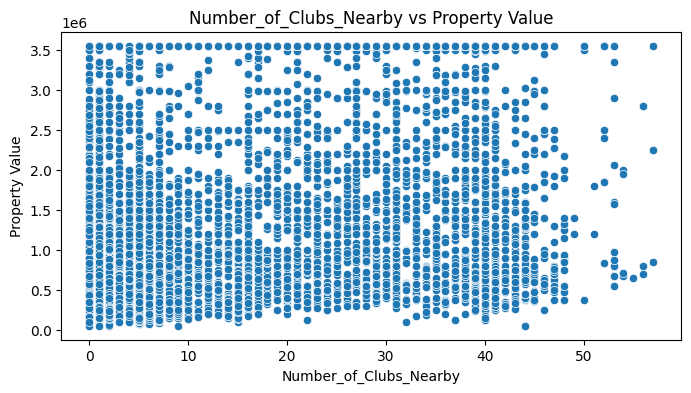

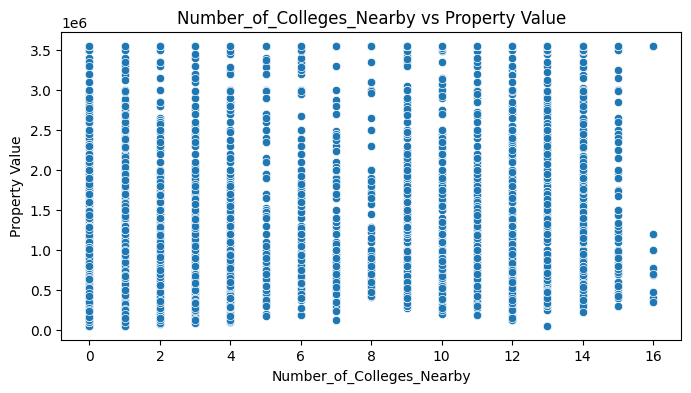

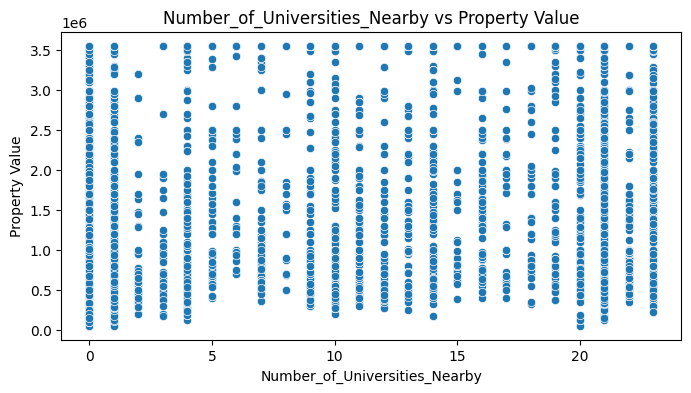

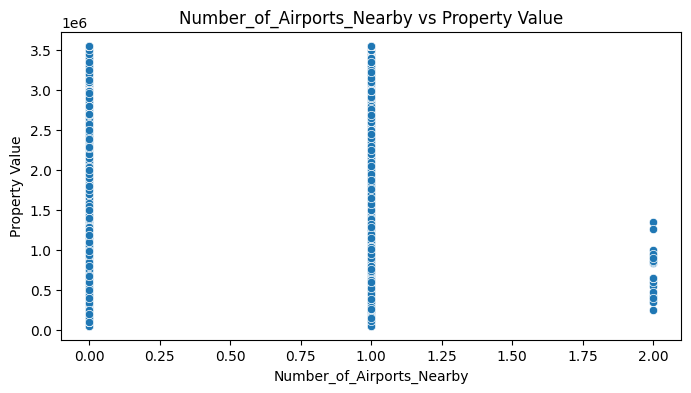

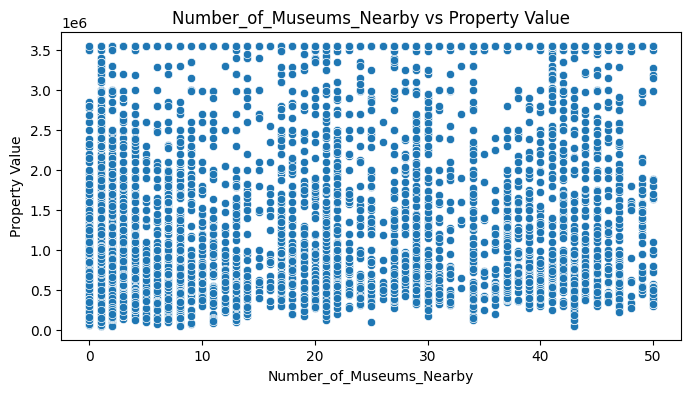

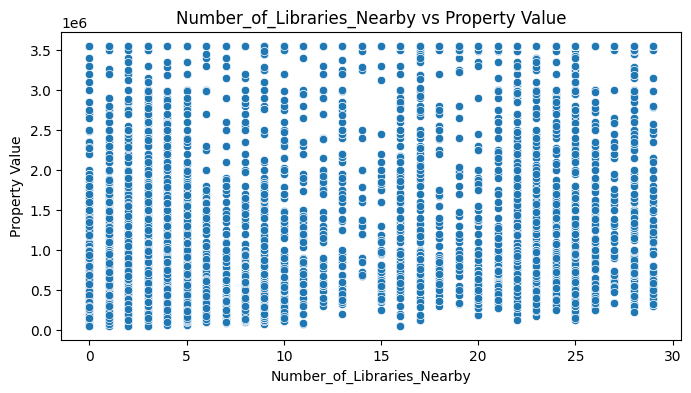

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in num_cols:
    if col not in ['Property Value', 'Latitude','Number_of_Buses_Nearby', 'Number_of_Grocery_stores_Nearby', 'Number_of_Trains_Nearby' , 'Longitude','Number_of_Metros_Nearby','Number_of_Restaurants_Nearby','Number_of_Schools_Nearby' , 'total lot size(sqft)','Area (Sqft)','Number_of_Parks_Nearby','Number_of_Malls_Nearby']:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=df[col], y=df['Property Value'])
        plt.title(f'{col} vs Property Value')
        plt.show()


## Analyzing Property Value by Categorical Features
We examine how property values vary across different categories using bar plots. These visualizations help identify which categorical factors (like property type or borough) show significant differences in average home prices. The plots will reveal potential patterns that could be valuable for our predictive model.

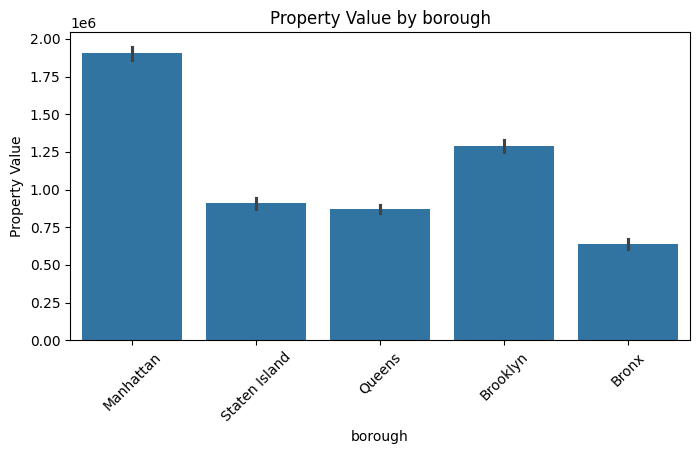

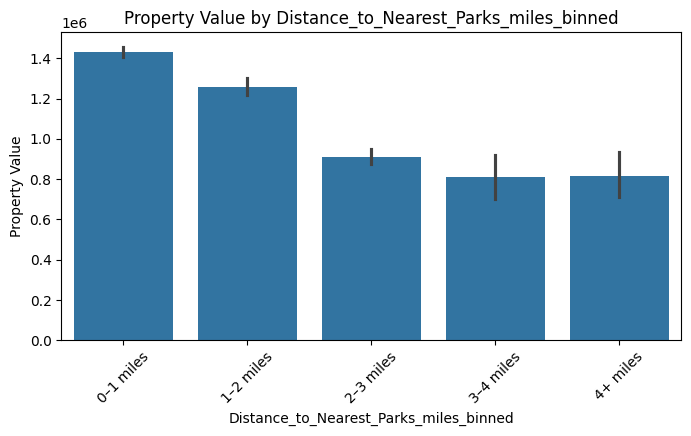

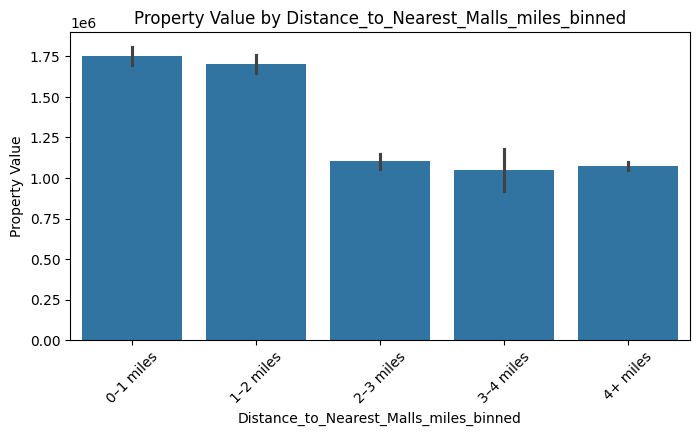

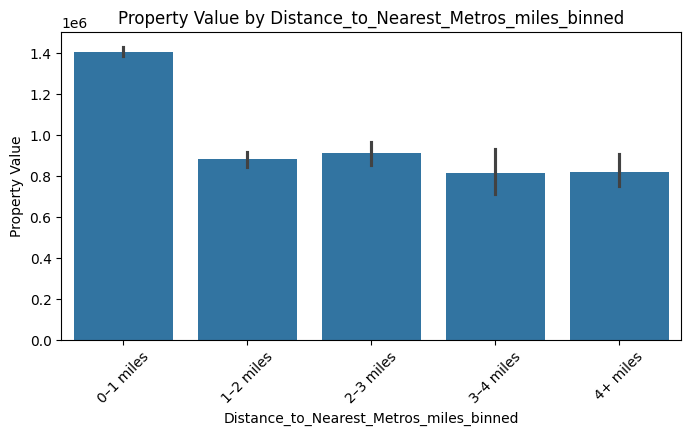

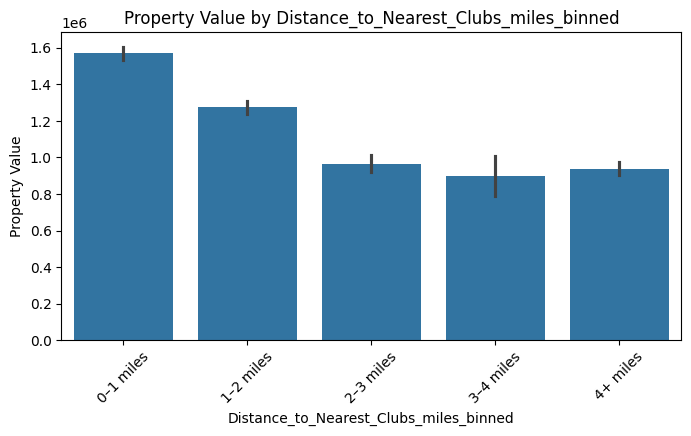

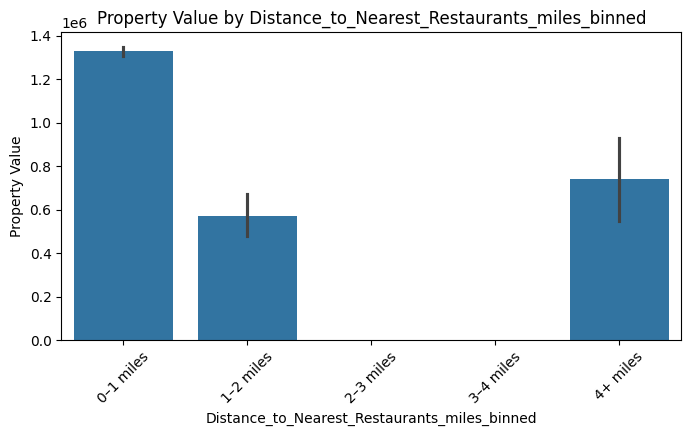

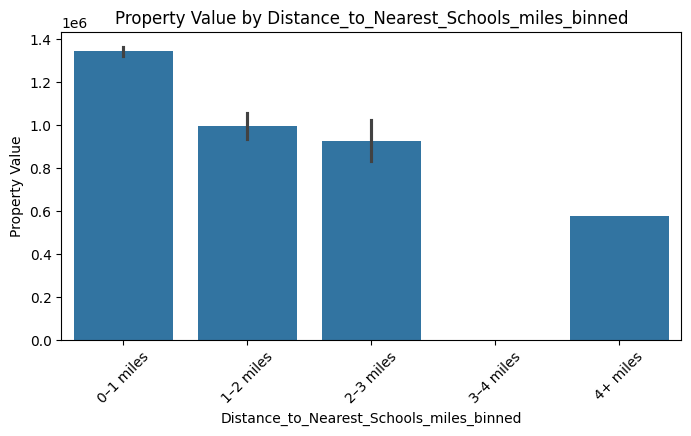

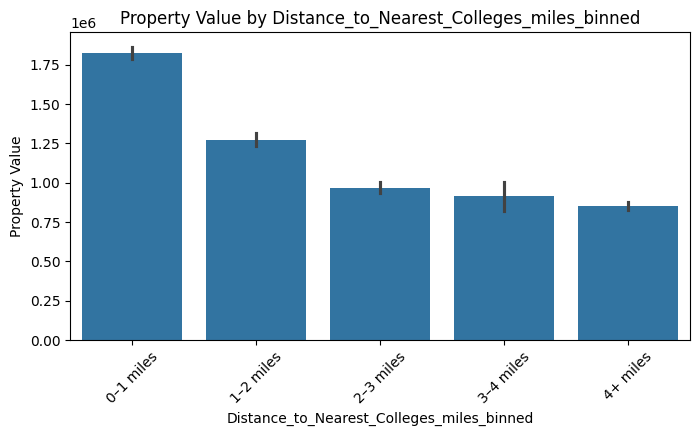

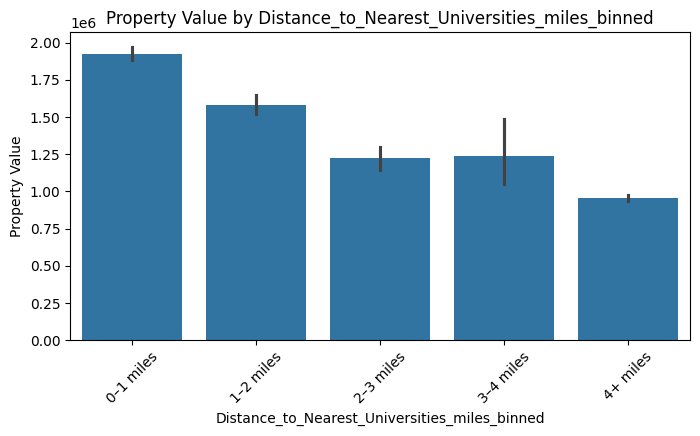

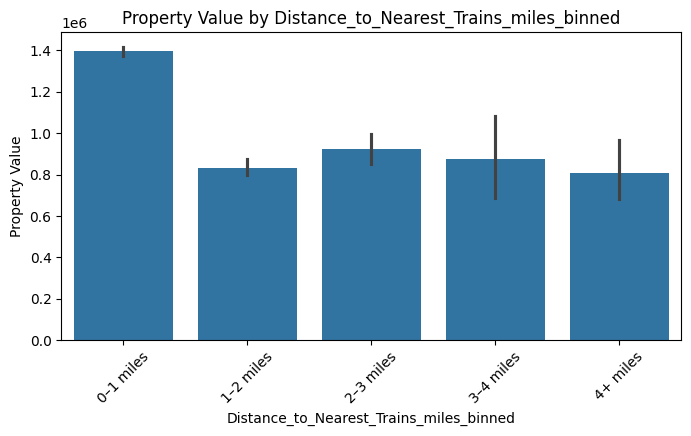

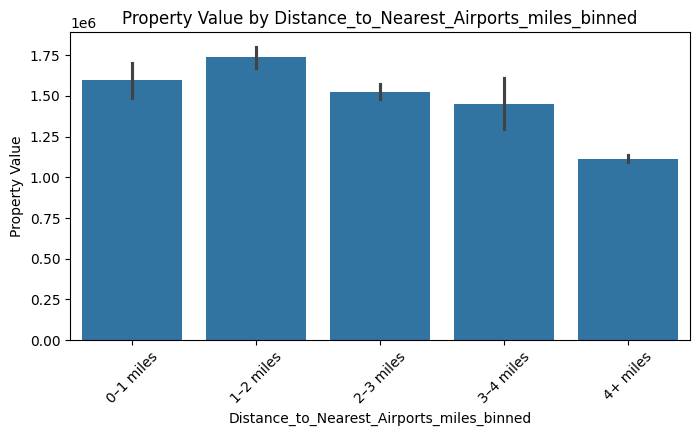

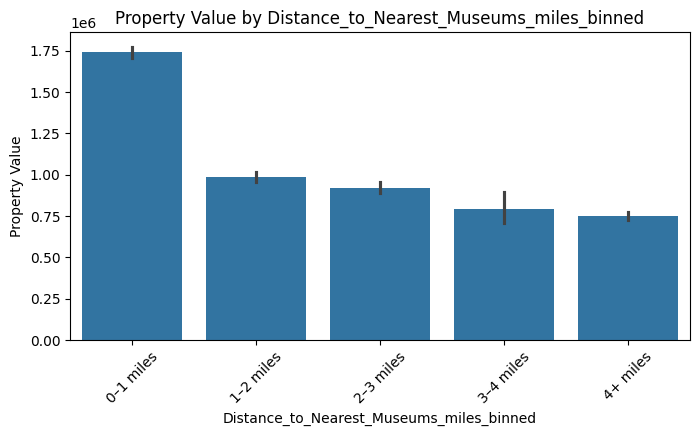

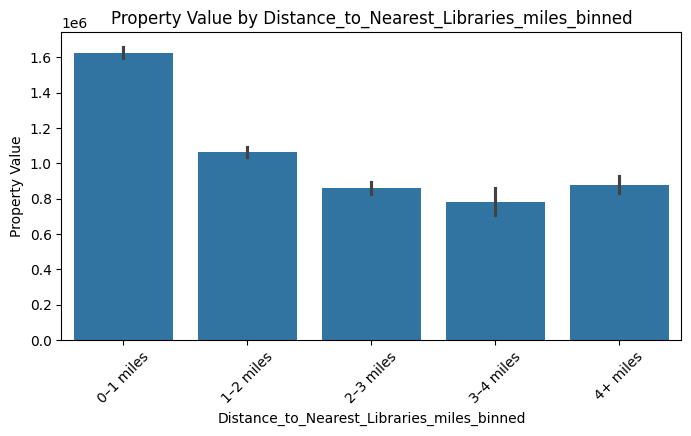

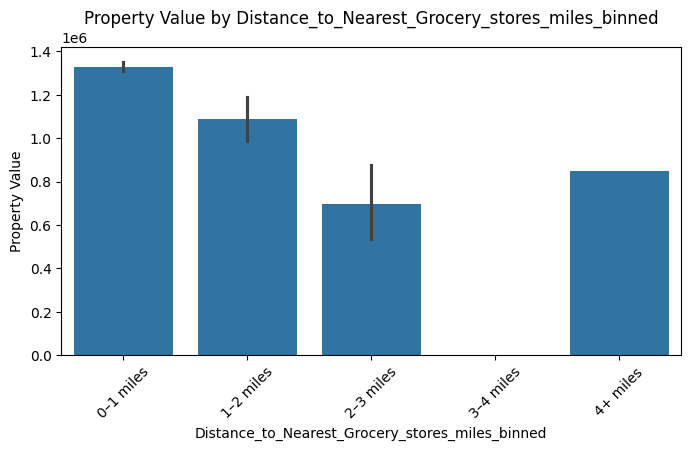

In [103]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    if col not in ['Type of House','bed','bath', 'Distance_to_Nearest_Buses_miles_binned']:
        plt.figure(figsize=(8, 4))
        sns.barplot(x=df[col], y=df['Property Value'])
        plt.title(f'Property Value by {col}')
        plt.xticks(rotation=45)
        plt.show()


**Amenity Proximity Analysis:**

The data reveals a clear pattern where properties closer to libraries, museums, universities, and train stations command significantly higher values, with prices decreasing steadily as distance increases. The exception is airports, where moderate proximity yields the highest values, likely balancing accessibility with noise concerns. These findings demonstrate that walkability to key amenities strongly influences property values, with transit access showing the most dramatic premium. Based on these insights, distance-to-amenity features should be prioritized in pricing models, while airport proximity may require special treatment to account for its non-linear relationship with value.

## Geospatial Analysis of Property Values
This scatter plot visualizes property locations using longitude and latitude coordinates, with color and point size representing property values. The visualization helps identify Geographic price clusters (high-value neighborhoods), Location-based price trends, and Potential spatial patterns that could inform location-based features in our model.

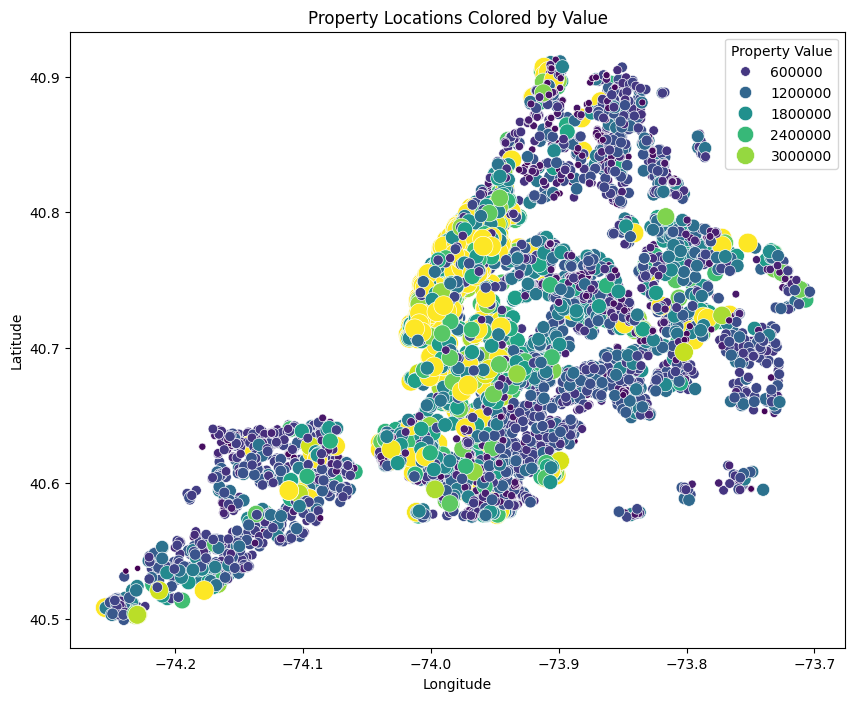

In [104]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Property Value', data=df, 
                palette='viridis', size='Property Value', sizes=(20, 200))
plt.title('Property Locations Colored by Value')
plt.show()

In [105]:
df.shape

(10470, 37)

## Log Transformation and Visualization of Target Variable
Applied a log transformation to the target variable to reduce its right skewness.

<Axes: >

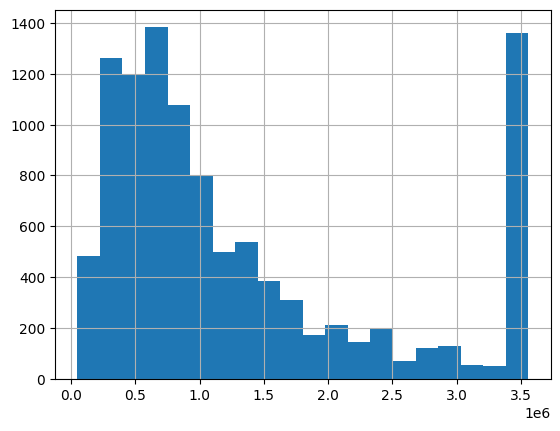

In [106]:
df['Property Value'].hist(bins = 20)

<Axes: >

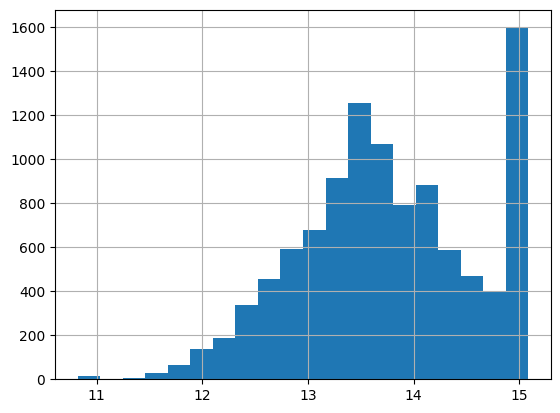

In [107]:
import matplotlib.pyplot as plt
df_encoded['Property Value_log'] = np.log1p(df_encoded['Property Value'])
df_encoded['Property Value_log'].hist(bins = 20)


## Correlation Map
This correlation heatmap focuses only on relationships with coefficients above 0.5, highlighting the strongest positive and negative associations in our dataset. By filtering for these significant correlations, we can identify the redundant features which can be removed, and key predictors that show strong relationships with our target variable (Property Value).

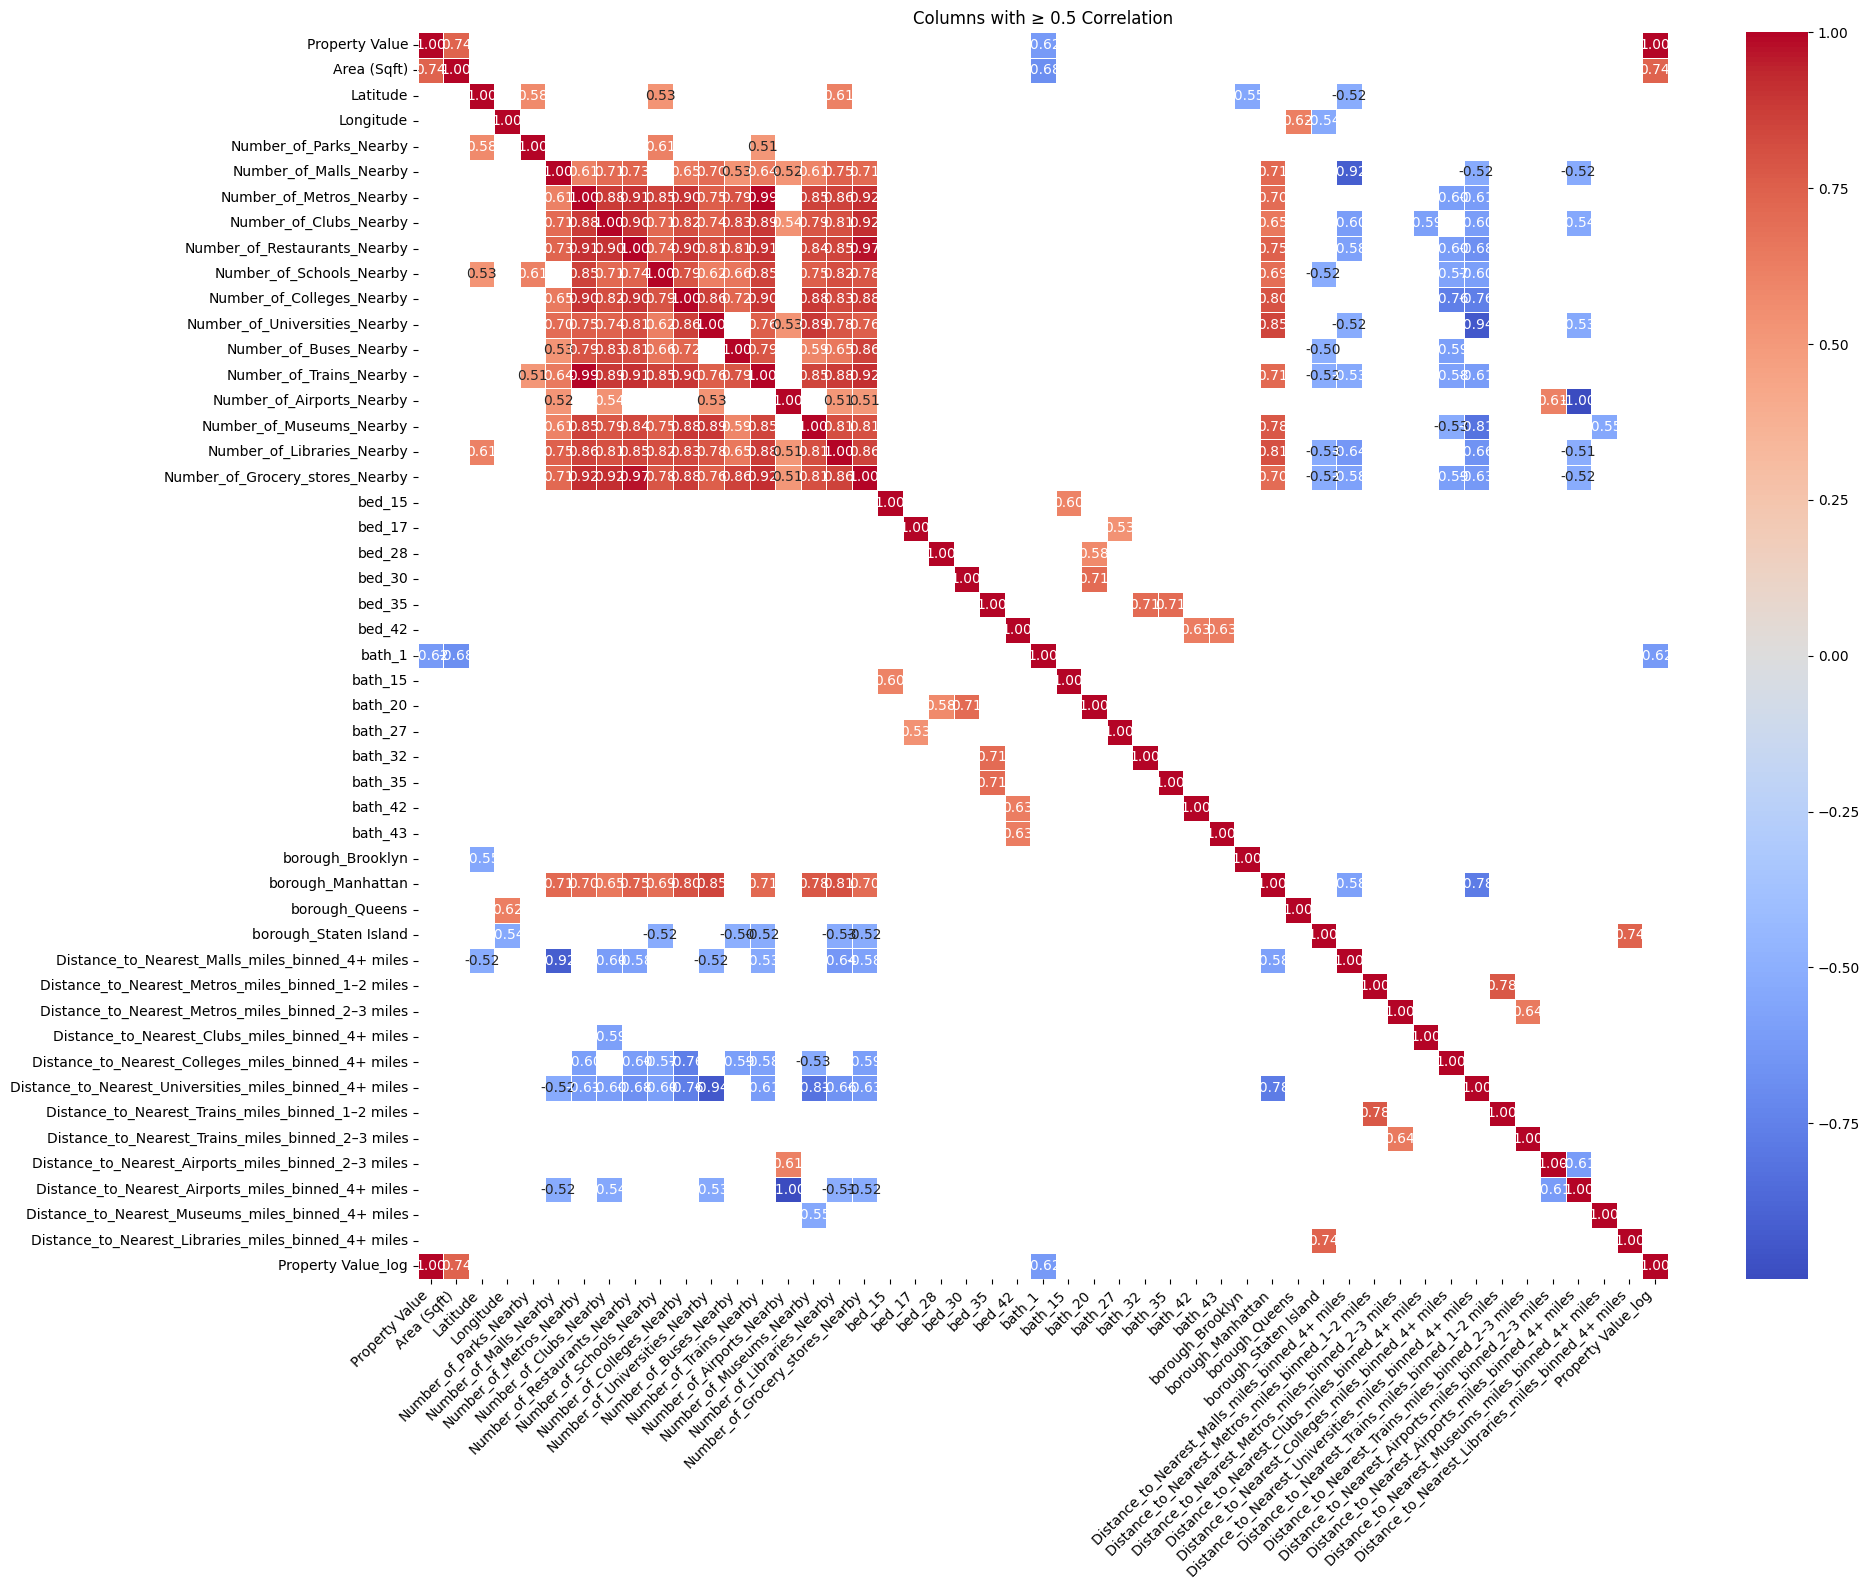

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df_encoded.corr(method='spearman')
threshold = 0.5

high_corr_cols = [
    col for col in corr_matrix.columns 
    if ((corr_matrix[col].abs() >= threshold) & (corr_matrix[col] != 1)).any()
]
filtered_corr = corr_matrix.loc[high_corr_cols, high_corr_cols]

plt.figure(figsize=(20, 16))
sns.heatmap(
    filtered_corr,
    annot=True,          
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    mask=(filtered_corr.abs() < threshold)  
)
plt.title(f"Columns with ≥ {threshold} Correlation")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [109]:
df_final = df_encoded.copy()

In [110]:
df_final.drop(columns=["Property Value"], inplace=True)
df_final

,Area (Sqft),Latitude,Longitude,Number_of_Parks_Nearby,Number_of_Malls_Nearby,Number_of_Metros_Nearby,Number_of_Clubs_Nearby,Number_of_Restaurants_Nearby,Number_of_Schools_Nearby,Number_of_Colleges_Nearby,...,Distance_to_Nearest_Museums_miles_binned_4+ miles,Distance_to_Nearest_Libraries_miles_binned_1–2 miles,Distance_to_Nearest_Libraries_miles_binned_2–3 miles,Distance_to_Nearest_Libraries_miles_binned_3–4 miles,Distance_to_Nearest_Libraries_miles_binned_4+ miles,Distance_to_Nearest_Grocery_stores_miles_binned_1–2 miles,Distance_to_Nearest_Grocery_stores_miles_binned_2–3 miles,Distance_to_Nearest_Grocery_stores_miles_binned_3–4 miles,Distance_to_Nearest_Grocery_stores_miles_binned_4+ miles,Property Value_log
0,4521.75,40.766474,-73.981266,16,3,110,30,2786,165,12,...,0,0,0,0,0,0,0,0,0,15.084695
1,2431.00,40.826130,-73.943006,37,0,72,5,572,220,4,...,0,0,0,0,0,0,0,0,0,13.383190
2,4521.75,40.787587,-73.969240,19,2,88,7,1933,192,9,...,0,0,0,0,0,0,0,0,0,15.084695
3,4521.75,40.595008,-74.106434,1,0,7,1,173,16,0,...,0,1,0,0,0,1,0,0,0,15.084695
4,1556.00,40.675746,-73.822413,14,1,30,7,252,32,1,...,1,1,0,0,0,0,0,0,0,12.520887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16607,832.00,40.705254,-74.010340,17,1,106,29,2371,165,9,...,0,0,0,0,0,0,0,0,0,14.070154
16608,1000.00,40.880917,-73.834635,25,0,24,1,83,72,1,...,0,0,1,0,0,0,0,0,0,11.918397
16609,2750.00,40.689108,-73.913931,33,0,83,24,817,150,2,...,0,0,1,0,0,0,0,0,0,13.989465
16610,1029.00,40.722400,-73.856690,12,2,45,13,827,57,1,...,0,1,0,0,0,0,0,0,0,13.120363


## Splitting data set

In [111]:
X = df_final.drop(columns=["Property Value_log"])
y = df_final["Property Value_log"]


In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Applying standard scalar

In [113]:
from sklearn.preprocessing import StandardScaler

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])


## Modeling

**Trying RandomForestRegresoor**

In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [115]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


RMSE: 0.28
R² Score: 0.8964


## Problems & Challenges

1. We faced numerous challenges while cleaning the dataset as it was completely scraped.
2. We are facing issues with appropriately incorporating the crime data into the model.

## Next steps

1. Deriving a safety score for localities based on crime hotspots
2. Developing Deep Neural Networks